# Training a dense neural network

The handwritten digit recognition is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a *perceptron*). First, let's start with quickly loading and normalizing the dataset, as we have done in the previous unit:

In [1]:
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install setuptools
%pip install distutils

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import requests

# Crear el directorio si no existe
# directory = os.path.expanduser('~/.keras/datasets')
directory = os.path.dirname(os.path.abspath('3-train-dense-neural-networks.ipynb'))
os.makedirs(directory, exist_ok=True)

# Descargar el archivo
url = 'https://github.com/MicrosoftDocs/tensorflowfundamentals/raw/main/data/mnist.npz'
response = requests.get(url)
file_path = os.path.join(directory, 'mnist.npz')

with open(file_path, 'wb') as file:
    file.write(response.content)

print(f'Archivo descargado en: {file_path}')

Archivo descargado en: c:\Proyectos_De_Acceso_Rapido\TensorFlow_Fundamentals\Train_Dense_Neural_Networks\mnist.npz


In [3]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data() 
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Fully-connected dense neural networks

A basic **neural network** consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Dense** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class). It is called dense because it contains all possible connections between 784 inputs and 10 outputs, 7840 total connections.

![Dense Neural Network Structure](notebooks/images/dense-one-layer-network.png)

As we discussed above, the dimension of our digit images is $28\times28$. Because the input dimension of a fully-connected layer is 784, we need to insert another layer into the network, called **Flatten**, to change tensor shape from $28\times28$ to $784$.

We want $n$-th output of the network to return the probability of the input digit being equal to $n$. Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called **Softmax**.

The architecture of our network can be represented by the following sequence of layers:

![An image showing the architecture of the network broken into a sequence of layers.](notebooks/images/one-layer-network-layers.png)

It can be defined in Keras in the following way, using `Sequential` syntax:


In [5]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.summary()

c:\Proyectos_De_Acceso_Rapido\TensorFlow_Fundamentals\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Once you have defined a network, you can call the `summary` method to display its architecture and other useful information, such as number of parameters in each layer.

When defining a network, it is important to remember to specify the dimension of the input tensor with the `input_shape` parameter. If you do not do that, Keras is unable to understand how many neurons are required to construct each layer. If `input_shape` is not provided you can still train the network but the summary will be incomplete.

## Anatomy of a Dense Layer

I have mentioned above that a dense layer contains 7840 weighted connections, however, in the `summary` above we see that our dense layer has 7850 parameters. Let's take some time to understand why.

The network input contains 784 pixels, which can be represented by a vector $x$ with 784 numbers. To get an output $z$ of dimension 10 we can multiply it by a matrix $W$ with dimensions $10\times784$: $z=W\times x$.

However, such multiplication defines a linear transformation without shift. Imagine we had only one input value, then the matrix would have just one weight, and the equation $W\times x$ would represent a straight line which goes through the point $(0,0)$. This would not be able to perform arbitrary classifications, because in some cases we also want some **shift** to happen. That means that we need a full equation for a straight line: $z=W\times x + b$, where $b$ is the **bias**.

Similarly, in a dense layer with 784 inputs and 10 outputs, the output would be calculated as $W\times x + b$, where the dimension of **weight** matrix $W$ is $784\times 10$, and the dimension of a **bias** vector $b$ is 10. This gives us $784\times 10 + 10 = 7850$ parameters. 

In Keras, we can get the weight matrix and bias from the `layers` property. Our dense layer is a second layer from the top, thus it can be access using `model.layers[1]`.

In [6]:
model.layers[1].weights

[<KerasVariable shape=(784, 10), dtype=float32, path=sequential/dense/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=sequential/dense/bias>]

As you can see, `weights` property of a layer returns a list of all weights, in our case it is the actual weight matrix called **kernel**, and a **bias**.

## Training the network

A network defined this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our dataset:

In [7]:
print('Digit to be predicted: ',y_train[0])
model(np.expand_dims(x_train[0],0))

Digit to be predicted:  5


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.15602078, 0.06510756, 0.06768715, 0.11823659, 0.07752899,
        0.09605048, 0.21499158, 0.03261252, 0.13550714, 0.03625719]],
      dtype=float32)>

The output of the network is the **tensor**, represented by the `ft.Tensor` object. The tensor type is very similar to a numpy array, however TensorFlow can operate on tensors very efficiently, shifting computations to GPU for better performance.

> **Note**: In fact, low-level TensorFlow API contains all basic tensor operations, similar to corresponding numpy operations on arrays. For example, you can use `tf.exp` on tensors, and it would be equivalent to calling `np.exp` on numpy arrays.

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognize the digits yet. We need to give it our training data to train it on our dataset.

To train the model we first need to **compile** it:

In [8]:
model.compile(optimizer='sgd',loss='categorical_crossentropy')

When building a model, we specify two important things:
* An **optimizer** that will be used to minimize the error. The simplest optimizer is **stochastic gradient descent**, or SGD; but with more complex networks other optimizers are often used, such as **Adam**
* A **loss function** will be used on the output of the network to obtain the error, which we will then minimize. For this model we will use **categorical cross-entropy** as the loss function.

To train the network, we need to provide an output for each training sample. We have **multi-class classification** problem since the network outputs probabilities for each digit from 0 to 9 (digits). 

We need the expected outputs to have the same layout, i.e. be a 10-number vector that contains 1 in only one position. This is called **one-hot encoding**. For example, digit 5 will be one-hot-encoded by a vector (0 0 0 0 0 1 0 0 0 0).

We can easily one-hot-encode training labels using Keras API:

In [9]:
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)
print("First 3 training labels:",y_train[:3])
print("One-hot-encoded version:\n",y_train_onehot[:3])

First 3 training labels: [5 0 4]
One-hot-encoded version:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Now, to do the actual training, we call the `fit` function:

In [10]:
model.fit(x_train,y_train_onehot)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1306


## Monitoring training

This training only loops through the dataset once, which is called one **epoch**. Normally we want training to go on for several epochs, and we can specify the number of epochs we want using a parameter.

Also, it is useful to evaluate the quality of the model on test and/or a validation datasets. It's important to test the model with unseen data because this will help indicate how well the model **generalizes** to other data beyond our dataset. To evaluate the error in between epochs, we can pass in validation data:

In [11]:
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=3)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4754 - val_loss: 0.4001
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4072 - val_loss: 0.3669
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3794 - val_loss: 0.3493


The `fit` function returns the **history** object that contains the loss data for each training epoch. It can be used to visualize the loss on the graph:

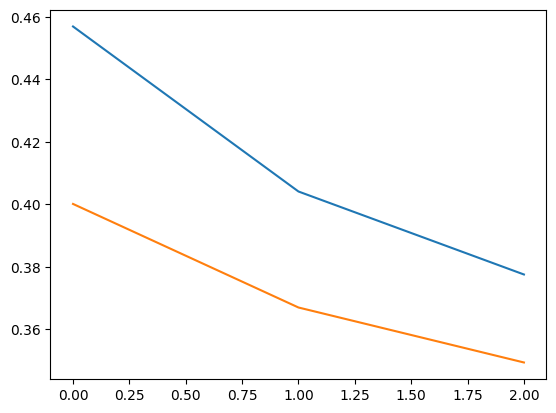

In [12]:
for x in ['loss','val_loss']:
    plt.plot(hist.history[x])

## Metrics and Minibatches

The value of the loss function does not tell us a lot about the accuracy of the model. To measure accuracy, we would want to see the percentage of correctly classified digits from the test dataset. In fact, we can add accuracy as a **metric** during dataset compilation, and it would be displayed and reported all the way through the training:

In [13]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=3,batch_size=128)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.8996 - loss: 0.3689 - val_acc: 0.9069 - val_loss: 0.3447
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.8993 - loss: 0.3657 - val_acc: 0.9078 - val_loss: 0.3416
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9004 - loss: 0.3594 - val_acc: 0.9076 - val_loss: 0.3387


In addition to using new accuracy metrics, we have specified `batch_size` parameter to define the number of samples that are being processed by the neural network at once. Since GPU computations are easily parallelizable, it is much more efficient to process several samples in one go. Larger minibatch size significantly speeds up learning process, but also makes it a little bit less precise. This is due to the fact that the direction of optimization is selected for the whole minibatch, and not for each individual sample. Thus, choosing minibatch size is quite tricky, and it remains one of the hyperparameters that can be further optimized to achieve better performance. 

## Specifying Optimizer Parameters

In the previous call to `compile`, we have been specifying optimizer, loss and metrics using keyword abbreviations, such as `sgd`. However, sometimes we might want to do some fine-tuning to optimizer parameters, or use custom loss function. In such cases, it is possible to pass objects instead of string abbreviations.

Let's use a variation of stochastic gradient descent, which is called **momentum SGD**. The idea is that the gradients of loss function will be averaged over the last few steps in order to keep the momentum, and make optimization more smooth. To turn our gradient descent into momentum SGD, we need to create `SDG` optimizer object explicitly, provide `momentum` parameter, and pass this object to `compile` method.

In [14]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)), 
        keras.layers.Dense(10,activation='softmax')])
model.compile(optimizer=keras.optimizers.SGD(momentum=0.5),loss='categorical_crossentropy',metrics=['acc'])
hist = model.fit(x_train,y_train_onehot,validation_data=(x_test,y_test_onehot), epochs=5, batch_size=64)  

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.7155 - loss: 1.1288 - val_acc: 0.8781 - val_loss: 0.4804
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8768 - loss: 0.4776 - val_acc: 0.8951 - val_loss: 0.3994
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8917 - loss: 0.4098 - val_acc: 0.9019 - val_loss: 0.3676
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.8965 - loss: 0.3832 - val_acc: 0.9073 - val_loss: 0.3483
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.8986 - loss: 0.3654 - val_acc: 0.9093 - val_loss: 0.3366


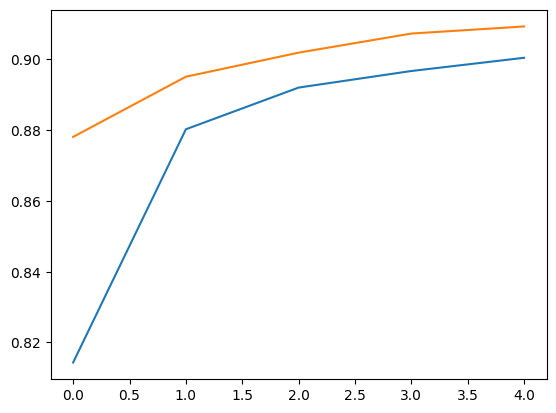

In [15]:
for x in ['acc','val_acc']:
    plt.plot(hist.history[x])

## Visualizing network weights

Now let's visualize the weights of our neural network and see what they look like. When the network is more complex than just one layer, making sense of the weight data is more difficult. However, in this example of classifying a digit in a one-layered perceptron happens by multiplying the initial image by a weight matrix, which allows us to visualize the network weights and see if they make any sense.

Let's create a `weight_tensor` which will have a dimension of 784x10. This tensor can be obtained by calling the `net.parameters()` method. In this example, if we want to see if our number is 0 or not, we will multiply input digit by `weight_tensor[0]` and pass the result through a softmax normalization to get the answer. This results in the weight tensor elements somewhat resembling the average shape of the digit it classifies:

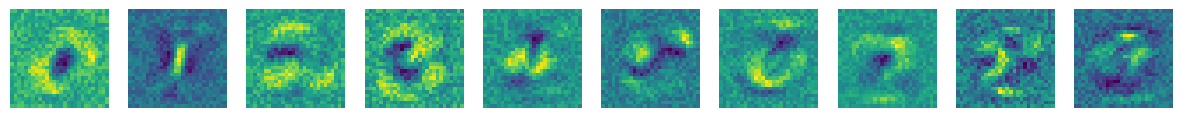

In [16]:
weight_tensor = model.layers[1].weights[0].numpy().reshape(28,28,10)
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i in range(10):
    ax[i].imshow(weight_tensor[:,:,i])
    ax[i].axis('off')

## Takeaway 

Training a neural network in Keras requires just one line of code and tweaking a few parameters. We can see that a single-layer dense neural network shows relatively good performance, but we definitely want to get higher than 91% on accuracy! In the next unit, we will try to use multi-level perceptrons.